# Quickstart guide to mapping and modelling disease

This practical is written to give you a rapid overview ofhow to get started building and analysing models. The learning aim here is not to teach everything, but to present one workflow that illustrates how you can move from an experimental dataset, to gene network maps, to models. Everything in this guide is expanded on in more depth later, including the practical and theoretical aspects, but you should be able to adapt this as a starting point for your own data.

## How mutation of APC alters cancer signalling 

"Differential RNA-seq analysis comparing APC-defective and APC-restored SW480 colorectal cancer cells"
https://doi.org/10.1016/j.gdata.2016.02.001

Adenomatous polyposis coli (APC) tumour suppressor gene is mutated in 80% of colorectal cancers (CRC). Its mutation is a well studied step in the Vogelstein model of tumour development. In this dataset APC has been restored in a CRC cell line, and gene expression changes measured with RNASeq. This dataset allows us to explore the role of APC in the control of the cancer phenotype.

In this tutorial we 

* Process the raw data
* Perform differential expression analysis to identify genes activated and inhibited by the reintroduction of APC
* Use GSEA to identify pathways changed by the presence or absence of APC (to be confirmed)
* Develop maps of signalling
* Convert these maps into models

In [26]:
import pandas as pd

# Loading and processing the input data

In [27]:
## rpkm_data
rpkm_data = pd.read_csv("./GSE76307_gene_level.rpkm.txt", sep = "\t", index_col = "Description")
## raw counts data
raw_counts = pd.read_csv("./GSE76307_transcript_counts.table.txt", sep = "\t", index_col = "Unnamed: 0")

### Curating the raw counts data

In [28]:
raw_counts.head()

,sw480_APC_1,sw480_APC_2,sw480_APC_3,sw480_CONTROL_1,sw480_CONTROL_2,sw480_CONTROL_3,sw480-1,sw480-2,sw480-3,cds_length,gene_name
NM_000014,1,1,3,1,2,2,3,2,2,4653,A2M
NM_000015,1,0,0,0,2,1,1,3,1,1317,NAT2
NM_000016,1038,1126,1098,1285,1037,1306,1022,1059,1057,2603,ACADM
NM_000017,133,111,103,171,136,174,143,147,125,1917,ACADS
NM_000018,8699,8232,8364,8888,8426,9188,10982,10844,11450,2292,ACADVL


In [29]:
## We summarise the raw counts transcipts to the gene level (just add them all up)

raw_counts = raw_counts.groupby(['gene_name']).sum()

raw_counts = raw_counts.drop("cds_length", axis =1)

In [30]:
raw_counts.head()

,sw480_APC_1,sw480_APC_2,sw480_APC_3,sw480_CONTROL_1,sw480_CONTROL_2,sw480_CONTROL_3,sw480-1,sw480-2,sw480-3
gene_name,,,,,,,,,
A1BG,3,0,2,0,0,2,0,1,3
A1BG-AS1,10,4,3,6,4,10,6,13,6
A1CF,6,0,6,0,0,6,6,18,6
A2M,1,1,3,1,2,2,3,2,2
A2M-AS1,3,6,3,4,3,3,6,11,16


### Curating the RPKM -> TPM data

In [31]:
rpkm_data.head()

,Name,sw480.1,sw480.2,sw480.3,sw480_APC_1,sw480_APC_2,sw480_APC_3,sw480_CONTROL_1,sw480_CONTROL_2,sw480_CONTROL_3
Description,,,,,,,,,,
DDX11L1,NR_046018,0.029243,0.000000,0.028825,0.000000,0.000000,0.000000,0.028771,0.032629,0.000000
WASH7P,NR_024540,10.022390,9.784377,10.255849,8.056397,7.294954,7.735621,7.657351,9.202215,8.199277
LOC729737,NR_039983,0.308885,0.281063,0.260970,0.572778,0.510475,0.507493,0.269165,0.167401,0.259120
LOC100132062,NR_028325,0.077384,0.022004,0.032690,0.043484,0.034878,0.011772,0.032629,0.037004,0.020941
LOC100288069,NR_033908,4.686485,5.611010,4.758363,3.776909,3.001679,3.752356,3.882773,3.853025,3.037023


In [32]:
## remove the name column
rpkm_data = rpkm_data.drop("Name", axis =1)

##### Convert rpkm to TPM

In [33]:
rpkm_data.head()

,sw480.1,sw480.2,sw480.3,sw480_APC_1,sw480_APC_2,sw480_APC_3,sw480_CONTROL_1,sw480_CONTROL_2,sw480_CONTROL_3
Description,,,,,,,,,
DDX11L1,0.029243,0.000000,0.028825,0.000000,0.000000,0.000000,0.028771,0.032629,0.000000
WASH7P,10.022390,9.784377,10.255849,8.056397,7.294954,7.735621,7.657351,9.202215,8.199277
LOC729737,0.308885,0.281063,0.260970,0.572778,0.510475,0.507493,0.269165,0.167401,0.259120
LOC100132062,0.077384,0.022004,0.032690,0.043484,0.034878,0.011772,0.032629,0.037004,0.020941
LOC100288069,4.686485,5.611010,4.758363,3.776909,3.001679,3.752356,3.882773,3.853025,3.037023


In [34]:
## TPM = (rpkm/total reads in sample) * 1 million
TPM_data = pd.DataFrame()

for col in rpkm_data.columns:
    totalreads = rpkm_data[col].sum()
    
    TPM_data[col] = rpkm_data[col].apply(lambda row: (row/totalreads) * 10**6)

In [35]:
TPM_data.head()

,sw480.1,sw480.2,sw480.3,sw480_APC_1,sw480_APC_2,sw480_APC_3,sw480_CONTROL_1,sw480_CONTROL_2,sw480_CONTROL_3
Description,,,,,,,,,
DDX11L1,0.073737,0.000000,0.071810,0.000000,0.000000,0.000000,0.070465,0.079016,0.000000
WASH7P,25.271794,24.974742,25.549966,19.396767,17.000899,18.372652,18.754201,22.284504,19.992728
LOC729737,0.778863,0.717417,0.650144,1.379034,1.189663,1.205333,0.659232,0.405385,0.631826
LOC100132062,0.195126,0.056166,0.081439,0.104692,0.081284,0.027960,0.079914,0.089611,0.051061
LOC100288069,11.817130,14.322172,11.854310,9.093372,6.995417,8.912112,9.509596,9.330662,7.405333


In [36]:
## We now have:
##  - raw counts data (use for input to DESeq and other tools requiring the raw counts)
##  - TPM data (use for visualisation, GSEA, and other similar tools required normalised data)

## Perform PCA to check samples are distinct

In [37]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaled_TPM = StandardScaler().fit_transform(TPM_data.T)

In [38]:
## Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_TPM)

In [39]:
## Make a dataframe and calculate the percentage contribution of each PC
principal_Df = pd.DataFrame(data = principal_components
             , columns = ['PC1', 'PC2'])

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.46778784 0.21758848]


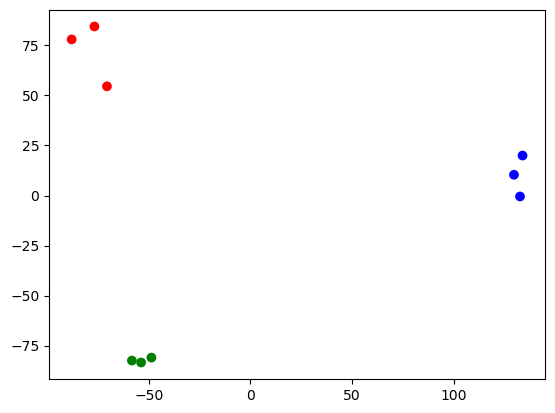

In [40]:
## Plot the PCs

## This can all be made to look a lot nicer and a bit more robust
import matplotlib.pyplot as plt

plt.scatter(x = principal_Df["PC1"], y = principal_Df["PC2"], c = ["r", "r", "r", "b", "b", "b", "g", "g", "g"])

plt.show()

# Differential expression using DESeq2 (generally this would be done in R, but as a python implementation is available I am using it)

### Set up our data

In [41]:
## raw counts is fed into deseq2 transposed compared to our usual format
counts_df = raw_counts.T

## We remove genes with very low counts (<10 counts across our samples)
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

In [42]:
counts_df.head()

gene_name,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A4GALT,A4GNT,AAAS,AACS,AACSP1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
sw480_APC_1,3,10,6,1,3,56,0,1769,1004,1,...,1181,3173,5611,231,576,1185,504,5068,1362,721
sw480_APC_2,0,4,0,1,6,49,0,1613,858,0,...,1152,3173,5673,232,567,1056,470,4459,1247,700
sw480_APC_3,2,3,6,3,3,37,0,1661,852,2,...,1140,3035,5720,187,591,1082,449,4781,1190,663
sw480_CONTROL_1,0,6,0,1,4,101,1,3163,732,4,...,1208,2945,6892,84,252,1637,708,7802,1342,870
sw480_CONTROL_2,0,4,0,2,3,84,1,2814,627,3,...,1090,2600,6026,78,241,1431,576,7876,1111,698


In [43]:
## We make our metadata matrix - in this case we just have one condition with 3 levels
conditions = ["APC_mut"] * 3 + ["Control"] * 3 + ["WT"] * 3

metadata = pd.DataFrame(conditions, index= raw_counts.columns, columns=["condition"])

In [44]:
metadata.head()

,condition
sw480_APC_1,APC_mut
sw480_APC_2,APC_mut
sw480_APC_3,APC_mut
sw480_CONTROL_1,Control
sw480_CONTROL_2,Control


## Run deseq2 with Control as the "base factor" (will do a comparison of the other two factors against the control)

In [45]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [46]:
## We make the deseqdataset (the data structure deseq uses)
inference = DefaultInference(n_cpus=8)
dds_control = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
    ref_level = ["condition", "Control"])

/home/benjamin/anaconda3/lib/python3.11/site-packages/pydeseq2/dds.py:250: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [47]:
## Run deseq2 (differential expression analysis)
dds_control.deseq2()

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 5.21 seconds.

Fitting dispersion trend curve...
... done in 1.08 seconds.

Fitting MAP dispersions...
... done in 5.46 seconds.

Fitting LFCs...
... done in 3.10 seconds.

Refitting 0 outliers.



In [48]:
## Look at the log fold change values
dds_control.varm["LFC"].head()

,intercept,condition_WT_vs_Control,condition_APC-mut_vs_Control
gene_name,,,
A1BG,-0.441712,0.691604,0.974337
A1BG-AS1,1.882836,0.199119,-0.125480
A1CF,0.654150,1.609863,0.758713
A2M,0.513939,0.295413,0.033406
A2M-AS1,1.201971,1.157952,0.217498


### Calcluate p values and shrink LFCs for APC mut vs Control

In [50]:
## APC mut vs Control

## Set up the pvalue calculation
stat_res_APCvsControl = DeseqStats(dds_control, inference=inference, contrast = ["condition", "APC-mut", "Control"], quiet = True)

## Calculate p values
stat_res_APCvsControl.summary(quiet = True)

## We shrink our fold changes
stat_res_APCvsControl.lfc_shrink(coeff="condition_APC-mut_vs_Control")

Log2 fold change & Wald test p-value: condition APC-mut vs Control
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
gene_name                                                                  
A1BG          1.201651        1.405671  1.971693  0.712926  4.758916e-01   
A1BG-AS1      6.768256       -0.181029  0.752814 -0.240470  8.099658e-01   
A1CF          5.196975        1.094592  1.217199  0.899271  3.685084e-01   
A2M           1.888791        0.048195  1.301985  0.037017  9.704716e-01   
A2M-AS1       6.021168        0.313784  0.847597  0.370204  7.112306e-01   
...                ...             ...       ...       ...           ...   
ZXDC       1443.856959       -0.470899  0.055675 -8.457938  2.721474e-17   
ZYG11B      600.154339       -0.442237  0.082114 -5.385676  7.217294e-08   
ZYX        7164.599004       -0.699490  0.071278 -9.813605  9.838925e-23   
ZZEF1      1355.558492        0.019842  0.065011  0.305218  7.602001e-01   
ZZZ3        771.52102

In [51]:
## Save our output
stat_res_APCvsControl.results_df.to_csv("APC_APCmut_vs_Control_LFC.csv")

In [52]:
stat_res_APCvsControl.results_df.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_name,,,,,,
A1BG,1.201651,0.180877,0.721680,0.712926,0.475892,0.572397
A1BG-AS1,6.768256,-0.088979,0.530282,-0.240470,0.809966,0.860557
A1CF,5.196975,0.317698,0.695540,0.899271,0.368508,0.465555
A2M,1.888791,0.011911,0.644403,0.037017,0.970472,0.980471
A2M-AS1,6.021168,0.137274,0.565664,0.370204,0.711231,0.783162


### Calcluate p values and shrink LFCs for WT vs Control

In [55]:
## WT vs Control

## Set up the pvalue calculation
stat_res_WTvsControl = DeseqStats(dds_control, inference=inference, contrast = ["condition", "WT", "Control"], quiet = True)

## Calculate p values
stat_res_WTvsControl.summary(quiet = True)

## We shrink our fold changes
stat_res_WTvsControl.lfc_shrink(coeff="condition_WT_vs_Control")

Log2 fold change & Wald test p-value: condition WT vs Control
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene_name                                                                     
A1BG          1.201651        0.997774  1.996850  0.499674  0.617305       NaN
A1BG-AS1      6.768256        0.287267  0.725602  0.395902  0.692177  0.795980
A1CF          5.196975        2.322542  1.173313  1.979473  0.047763  0.102712
A2M           1.888791        0.426190  1.256309  0.339240  0.734429       NaN
A2M-AS1       6.021168        1.670571  0.779962  2.141862  0.032205  0.073796
...                ...             ...       ...       ...       ...       ...
ZXDC       1443.856959        0.021101  0.053746  0.392598  0.694617  0.797742
ZYG11B      600.154339       -0.038229  0.079441 -0.481224  0.630357  0.749374
ZYX        7164.599004        0.104478  0.070800  1.475673  0.140032  0.245832
ZZEF1      1355.558492        0.195392  0.064272  3.040077  0.002365 

In [56]:
## Save our output
stat_res_WTvsControl.results_df.to_csv("APC_WT_vs_Control_LFC.csv")

In [57]:
### To get the final comparison (APC vs WT) we need to rerun deseq2 with WT as the "base factor"

In [58]:
## We make the deseqdataset (the data structure deseq uses)
inference = DefaultInference(n_cpus=8)
dds_WT = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
    ref_level = ["condition", "WT"])

/home/benjamin/anaconda3/lib/python3.11/site-packages/pydeseq2/dds.py:250: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [59]:
## Run deseq2 (differential expression analysis)
dds_WT.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 5.63 seconds.

Fitting dispersion trend curve...
... done in 0.93 seconds.

Fitting MAP dispersions...
... done in 5.73 seconds.

Fitting LFCs...
... done in 3.24 seconds.

Refitting 0 outliers.



### Calculate p values and shrink LFC for APC vs WT

In [60]:
## APC vs WT

## Set up the pvalue calculation
stat_res_APCvsWT = DeseqStats(dds_WT, inference=inference, contrast = ["condition", "APC-mut", "WT"], quiet = True)

## Calculate p values
stat_res_APCvsWT.summary(quiet = True)

## We shrink our fold changes
stat_res_APCvsWT.lfc_shrink(coeff="condition_APC-mut_vs_WT")

Log2 fold change & Wald test p-value: condition APC-mut vs WT
              baseMean  log2FoldChange     lfcSE       stat        pvalue  \
gene_name                                                                   
A1BG          1.201651        0.407894  1.825031   0.223500  8.231464e-01   
A1BG-AS1      6.768256       -0.468301  0.738071  -0.634493  5.257591e-01   
A1CF          5.196975       -1.227948  1.090972  -1.125554  2.603542e-01   
A2M           1.888791       -0.377989  1.256532  -0.300819  7.635525e-01   
A2M-AS1       6.021168       -1.356785  0.757268  -1.791684  7.318367e-02   
...                ...             ...       ...        ...           ...   
ZXDC       1443.856959       -0.492000  0.055491  -8.866260  7.564388e-19   
ZYG11B      600.154339       -0.404008  0.082065  -4.923026  8.521602e-07   
ZYX        7164.599004       -0.803968  0.071191 -11.293139  1.418779e-29   
ZZEF1      1355.558492       -0.175549  0.064355  -2.727828  6.375287e-03   
ZZZ3        77

In [61]:
## Save our output
stat_res_APCvsWT.results_df.to_csv("APC_APCmut_vs_WT_LFC.csv")

## We have now performed differential expression - to get genes of interest we need to calculate overlaps. The genes changed by APC manipulation should be those that overlap between the two APC mut comparisons, but excluding those different between WT and control

In [62]:
## APCmut vs WT
APCmut_vs_WT = stat_res_APCvsWT.results_df[stat_res_APCvsWT.results_df["padj"] <= 0.05]

APCmut_vs_WT = APCmut_vs_WT[abs(APCmut_vs_WT["log2FoldChange"]) > 2]

APCmut_vs_WT_genes = set(APCmut_vs_WT.index.tolist())

In [63]:
## APCmut vs Control
APCmut_vs_Control = stat_res_APCvsControl.results_df[stat_res_APCvsControl.results_df["padj"] <= 0.05]

APCmut_vs_Control = APCmut_vs_Control[abs(APCmut_vs_Control["log2FoldChange"]) > 2]

APCmut_vs_Control_genes = set(APCmut_vs_Control.index.tolist())

In [64]:
## WT vs Control
WT_vs_Control = stat_res_WTvsControl.results_df[stat_res_WTvsControl.results_df["padj"] <= 0.05]

WT_vs_Control = WT_vs_Control[abs(WT_vs_Control["log2FoldChange"]) > 2]

WT_vs_Control_genes = set(WT_vs_Control.index.tolist())

## Make a venn diagram

In [66]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

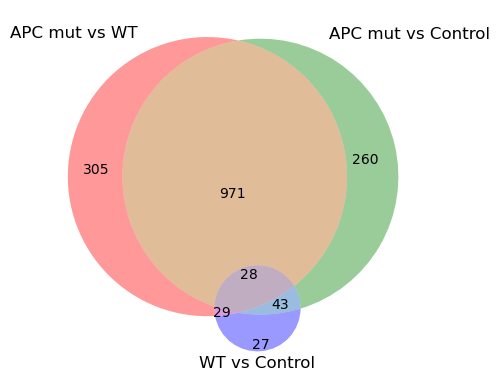

In [67]:
venn3([APCmut_vs_WT_genes, APCmut_vs_Control_genes, WT_vs_Control_genes]
     ,set_labels = ("APC mut vs WT", "APC mut vs Control", "WT vs Control"))
plt.show()

In [68]:
#### 968 genes are overlapping in the mutant conditions and not involved in the vector

In [69]:
APCmut_genes = list((APCmut_vs_Control_genes & APCmut_vs_WT_genes) - WT_vs_Control_genes)

## Make a heatmap

In [70]:
heatmap_genes = TPM_data.T[APCmut_genes].T

heatmap_genes = heatmap_genes.loc[~(heatmap_genes==0).all(axis=1)]


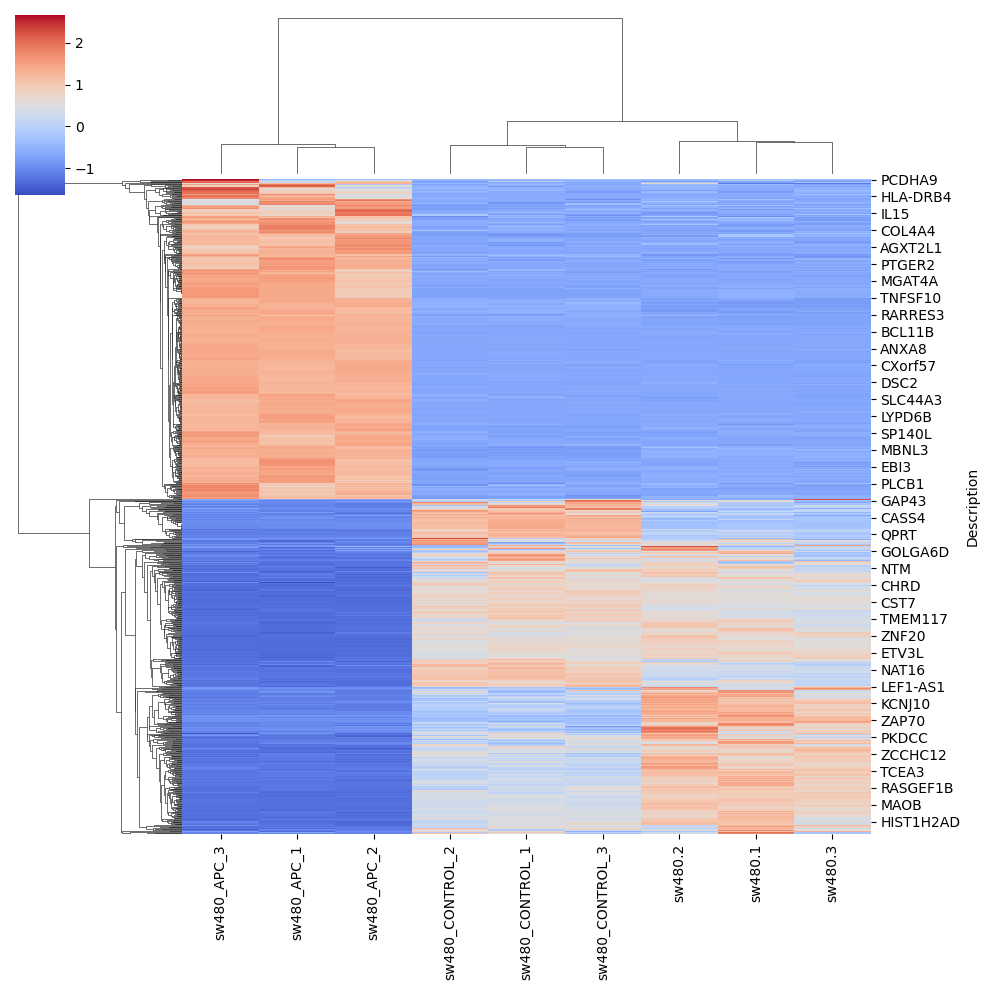

In [71]:
import seaborn as sns
sns.clustermap(heatmap_genes, z_score= 0, metric= "euclidean", cmap = "coolwarm")
plt.show()

## Do some enrichment

In [75]:
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)
gp.profile(organism='hsapiens',
            query=APCmut_genes)

ImportError: cannot import name 'GProfiler' from 'gprofiler' (/home/benjamin/anaconda3/lib/python3.11/site-packages/gprofiler/__init__.py)

In [74]:
import gseapy as gp

enr = gp.enrichr(gene_list=APCmut_genes, # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

ModuleNotFoundError: No module named 'gseapy'

In [ ]:
enr.results

In [ ]:
## Gene list which can be copy-pasted into many online tools as well
for item in APCmut_genes:
    print(item)

# Getting started with mapping networks

